In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import models
import cv2
from utilities import *

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget

In [6]:
groups = get_groups()

In [7]:
final_data = groups.iloc[7:]
final_data

,group_code,people_ID,ai_images,web_images,final_submissions
8,8,"[8A, 8B]","[data\ai\8A_11.jpg, data\ai\8A_12.jpg, data\ai...","[data\web\8A_1.jpg, data\web\8A_10.JPG, data\w...","[data\final_submissions\8\4.jpg, data\final_su..."
9,9,"[9A, 9B]","[data\ai\9A_11.png, data\ai\9A_12.png, data\ai...","[data\web\9A_1. .png, data\web\9A_10.png, data...","[data\final_submissions\9\8.jpg, data\final_su..."
10,10,"[10A, 10B]","[data\ai\10A_11.png, data\ai\10A_12.png, data\...","[data\web\10A_1.jpg, data\web\10A_10.png, data...","[data\final_submissions\10\2.jpg, data\final_s..."
11,11,"[11A, 11B]","[data\ai\11A_11.png, data\ai\11A_12.png, data\...","[data\web\11A_1.png, data\web\11A_10.jpg, data...","[data\final_submissions\11\14.jpg, data\final_..."
12,12,"[12A, 12B]","[data\ai\12A_11.png, data\ai\12A_12.png, data\...","[data\web\12A_1.jpg, data\web\12A_10.jpg, data...","[data\final_submissions\12\5.jpg, data\final_s..."
13,13,"[13A, 13B]","[data\ai\13A_11.png, data\ai\13A_12.png, data\...","[data\web\13A_1.png, data\web\13A_10.png, data...","[data\final_submissions\13\2.jpg, data\final_s..."
14,14,"[14A, 14B]","[data\ai\14A_11.png, data\ai\14A_12.png, data\...","[data\web\14A_1.png, data\web\14A_10.png, data...","[data\final_submissions\14\1.jpg, data\final_s..."
15,15,"[15A, 15B]","[data\ai\15A_11.PNG, data\ai\15A_12.PNG, data\...","[data\web\15A_1.jpg, data\web\15A_2.jpg, data\...","[data\final_submissions\15\2.jpg, data\final_s..."
16,16,"[16A, 16B]","[data\ai\16A_11.png, data\ai\16A_12.png, data\...","[data\web\16B_1.png, data\web\16B_10.png, data...","[data\final_submissions\16\3.jpg, data\final_s..."
17,17,"[17A, 17B]","[data\ai\17A_11.png, data\ai\17A_12.png, data\...","[data\web\17A_1.png, data\web\17A_2.png, data\...","[data\final_submissions\17\2.jpg, data\final_s..."


# Calculating similarity

In [8]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
    
def load_img(path,resize_shape=None) -> np.ndarray:
    img = cv2.imread(path)
    if resize_shape == None:
        return np.float32(img)/255
    return np.float32(cv2.resize(img,resize_shape))/255
    
def img_to_tensor(img,device):
    return preprocess_image(
        img,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ).to(device)

def calculate_similarity(inspiration, final_image, model:ResnetFeatureExtractor, device):
    inspiration_tensor = img_to_tensor(inspiration,device)
    final_image_tensor = img_to_tensor(final_image,device)

    features_inspiration = model(inspiration_tensor)[0,:]
    features_final = model(final_image_tensor)[0,:]

    return np.float32(torch.nn.functional.cosine_similarity(features_inspiration,features_final,dim=0).cpu().detach().numpy())

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True).to(device)
resnet.eval()
model = ResnetFeatureExtractor(resnet)

c:\Users\Luki\anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luki\anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Calculating cross-similarity for group 8
AI total similarity:	121.1101542711258
Web total similarity:	113.6874306499958
Two most similar images are these:


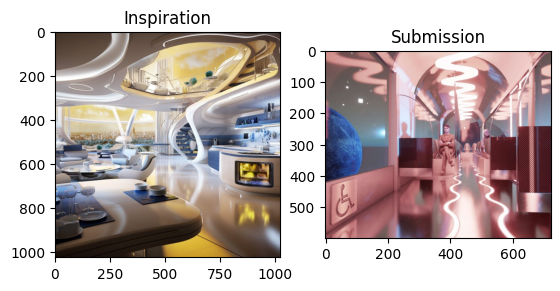

Calculating cross-similarity for group 9
AI total similarity:	114.34081315994263
Web total similarity:	115.70115113258362
Two most similar images are these:


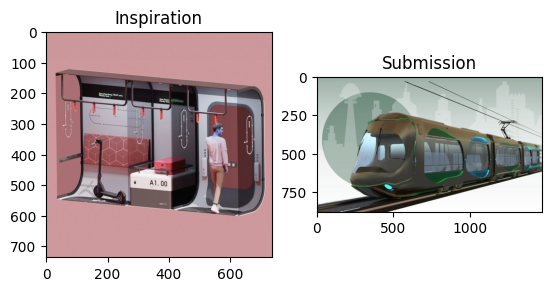

Calculating cross-similarity for group 10
AI total similarity:	21.187704980373383
Web total similarity:	26.848768711090088
Two most similar images are these:


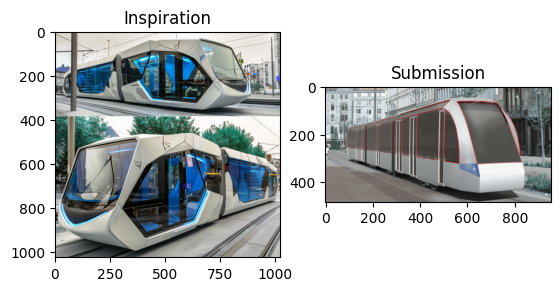

Calculating cross-similarity for group 11
AI total similarity:	211.69531565904617
Web total similarity:	206.4102363884449
Two most similar images are these:


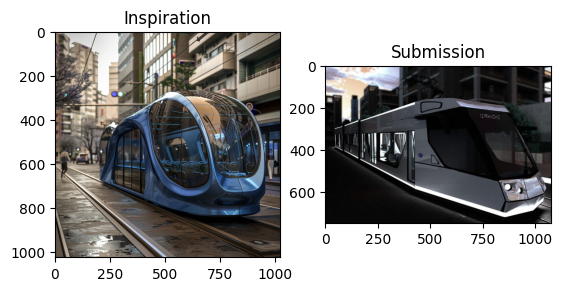

Calculating cross-similarity for group 12
AI total similarity:	50.44496554136276
Web total similarity:	95.73659288883209
Two most similar images are these:


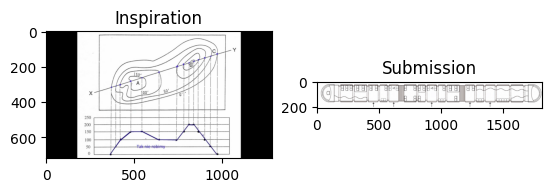

Calculating cross-similarity for group 13
AI total similarity:	144.04610830545425
Web total similarity:	123.19290161132812
Two most similar images are these:


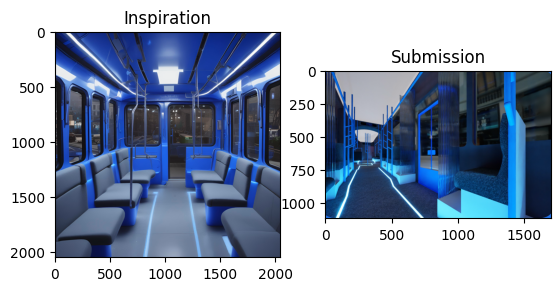

Calculating cross-similarity for group 14
AI total similarity:	44.780869483947754
Web total similarity:	38.73376816511154
Two most similar images are these:


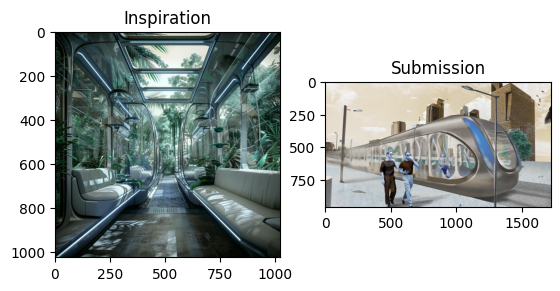

Calculating cross-similarity for group 15
AI total similarity:	123.22290855646133
Web total similarity:	168.55854988098145
Two most similar images are these:


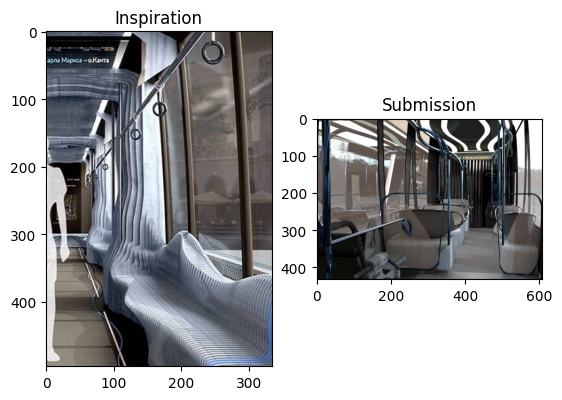

Calculating cross-similarity for group 16
AI total similarity:	105.38529944419861
Web total similarity:	109.88936644792557
Two most similar images are these:


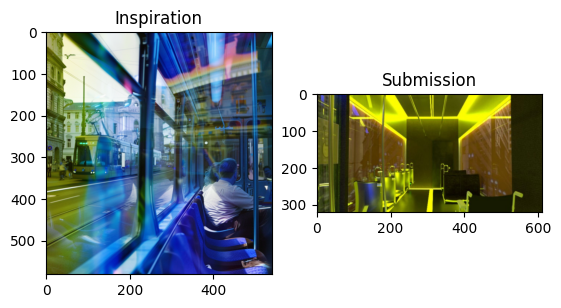

Calculating cross-similarity for group 17
AI total similarity:	27.108101725578308
Web total similarity:	80.51807135343552
Two most similar images are these:


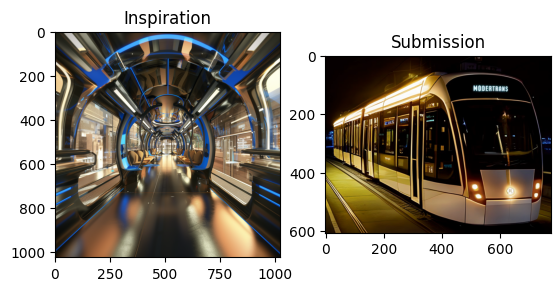

Calculating cross-similarity for group 18
AI total similarity:	0
Web total similarity:	0
Two most similar images are these:
No images to compare
Calculating cross-similarity for group 19
AI total similarity:	85.64466762542725
Web total similarity:	0
Two most similar images are these:


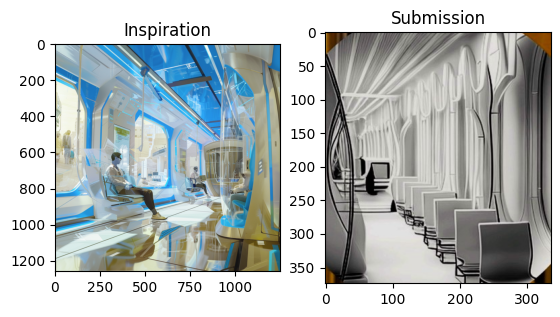

Calculating cross-similarity for group 20
AI total similarity:	172.39652174711227
Web total similarity:	89.70412763953209
Two most similar images are these:


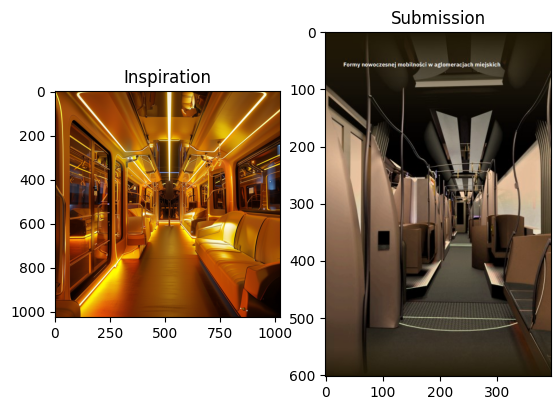

Calculating cross-similarity for group 21
AI total similarity:	0
Web total similarity:	201.86378625035286
Two most similar images are these:


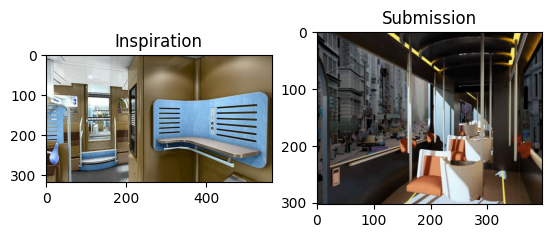

Calculating cross-similarity for group 22
AI total similarity:	0
Web total similarity:	0
Two most similar images are these:
No images to compare
Calculating cross-similarity for group 23
AI total similarity:	0
Web total similarity:	0
Two most similar images are these:
No images to compare
Calculating cross-similarity for group 24
AI total similarity:	0
Web total similarity:	0
Two most similar images are these:
No images to compare
Calculating cross-similarity for group 25
AI total similarity:	0
Web total similarity:	45.64042019844055
Two most similar images are these:


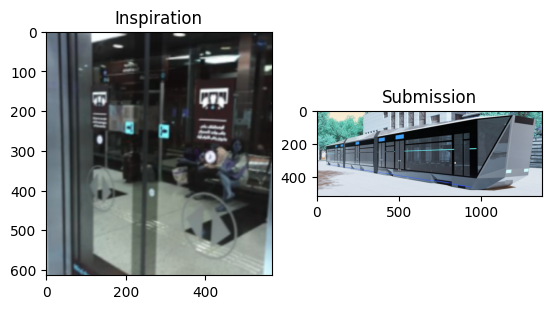

Calculating cross-similarity for group 26
AI total similarity:	31.72016352415085
Web total similarity:	0
Two most similar images are these:


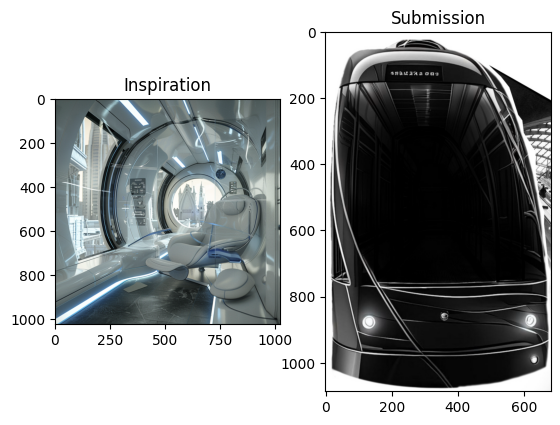

Calculating cross-similarity for group 27
AI total similarity:	0
Web total similarity:	0
Two most similar images are these:
No images to compare


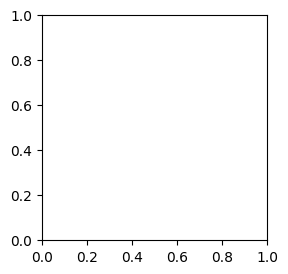

In [10]:
for i in range(len(final_data)):
    print(f'Calculating cross-similarity for group {final_data.iloc[i].group_code}')
    ai = final_data.iloc[i].ai_images
    web = final_data.iloc[i].web_images
    final = final_data.iloc[i].final_submissions
    ai_aggregated_similarity, web_aggregated_similarity = 0, 0
    max_similarity, picture1, picture2 = 0, "", ""

    for ai_photo in ai:
        im1 = load_img(ai_photo)
        for final_photo in final:
            im2 = load_img(final_photo)
            similarity = calculate_similarity(im1, im2, model, device) # placebo for now
            ai_aggregated_similarity += similarity
            if similarity > max_similarity:
                max_similarity = similarity
                picture1, picture2 = im1, im2
            
    print(f'AI total similarity:\t{ai_aggregated_similarity}')
    
    for web_photo in web:
        im1 = load_img(web_photo)
        for final_photo in final:
            im2 = load_img(final_photo)
            similarity = calculate_similarity(im1, im2, model, device) # placebo for now
            web_aggregated_similarity += similarity
            if similarity > max_similarity:
                max_similarity = similarity
                picture1, picture2 = im1, im2
    
    print(f'Web total similarity:\t{web_aggregated_similarity}')

    try:
        print('Two most similar images are these:')
        plt.subplot(1, 2, 1)
        plt.imshow(picture1)
        plt.title("Inspiration")
        plt.subplot(1, 2, 2)
        plt.imshow(picture2)
        plt.title("Submission")
        plt.show()
    except Exception:
        print('No images to compare')

Very primitive approach. Future ideas:
 - Use selective search or region proposal network across all images at the same time to extract the features from inspiration and final images
 - Create some ranking of highest similarity between images and display the most similar images.